In [350]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [351]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [352]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

DATA PREPROCESSING

In [353]:
# Define the ticker symbol and the date range
ticker = 'MSFT'
start_date = '2019-12-01'
end_date = '2025-06-30' # Adjust end date as needed

# Fetch the data
df_download = yf.download(ticker, start=start_date, end=end_date)

/var/folders/63/lpwssx6x59gb12p2395wtvfw0000gn/T/ipykernel_2617/2117433734.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_download = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [354]:
df_download.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df = df_download.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Close,High,Low,Open,Volume
0,2019-12-02,141.994949,144.159766,140.827091,144.140772,27418400
1,2019-12-03,141.767075,141.881008,139.241450,140.039026,24066000
2,2019-12-04,142.279770,142.593086,141.662598,142.555113,17574700
3,2019-12-05,142.355698,142.726009,141.928434,142.469645,17869100
4,2019-12-06,144.083786,144.197719,142.678558,143.362185,16403500
...,...,...,...,...,...,...
1395,2025-06-23,484.295959,486.039824,470.853269,476.533265,24864000
1396,2025-06-24,488.391510,490.125430,485.093118,487.235604,22305600
1397,2025-06-25,490.543976,492.825955,487.674099,490.314802,17495100
1398,2025-06-26,495.705811,496.293738,491.082065,491.251482,21578900


In [355]:
df['Close_Yesterday'] = df['Close'].shift(1)
df['High_Yesterday'] = df['High'].shift(1)
df['Low_Yesterday'] = df['Low'].shift(1)
df['Open_Yesterday'] = df['Open'].shift(1)
df['Volume_Yesterday'] = df['Volume'].shift(1)
df['High_Low_Range'] = df['High'] - df['Low']
df['MA5_Weekly'] = df['Close'].rolling(window=5, min_periods=1).mean()
df['MA21_Monthly'] = df['Close'].rolling(window=21, min_periods=1).mean()
df['Vol_W_MA5'] = df['Volume'].rolling(window=5, min_periods=1).mean()
df['Vol_M_MA21'] = df['Volume'].rolling(window=21, min_periods=1).mean()
df['C_EMA5_Weekly'] = df['Close'].ewm(span=5, adjust=False).mean()
df['C_EMA21_Monthly'] = df['Close'].ewm(span=21, adjust=False).mean()
df['Vol_W_EMA5'] = df['Volume'].ewm(span=5, adjust=False).mean()
df['Vol_M_EMA21'] = df['Volume'].ewm(span=21, adjust=False).mean()

ranged_df = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2024-12-31')]
cleaned_df = ranged_df.drop(columns=['High','Low', 'Open', 'Volume'])
cleaned_df

,Date,Close,Close_Yesterday,High_Yesterday,Low_Yesterday,Open_Yesterday,Volume_Yesterday,High_Low_Range,MA5_Weekly,MA21_Monthly,Vol_W_MA5,Vol_M_MA21,C_EMA5_Weekly,C_EMA21_Monthly,Vol_W_EMA5,Vol_M_EMA21
21,2020-01-02,152.505692,149.733185,149.799655,148.546333,148.850174,18369400.0,2.278749,150.690274,146.891089,18054660.0,2.121462e+07,150.681132,147.628041,1.971575e+07,2.188052e+07
22,2020-01-03,150.606720,152.505692,152.610135,150.331386,150.758649,22622100.0,1.794519,150.680780,147.312024,19373780.0,2.107415e+07,150.656328,147.898830,2.018257e+07,2.181104e+07
23,2020-01-06,150.996033,150.606720,151.869532,150.075013,150.321887,21116200.0,2.459168,150.694080,147.727084,19853960.0,2.122839e+07,150.769563,148.180394,2.039294e+07,2.172037e+07
24,2020-01-07,149.619263,150.996033,151.062503,148.603335,149.144547,20813700.0,2.231272,150.692178,148.072968,20911100.0,2.140768e+07,150.386130,148.311200,2.080666e+07,2.171253e+07
25,2020-01-08,152.002441,149.619263,151.603675,149.372403,151.271365,21634100.0,2.706027,151.146030,148.450047,22786520.0,2.194782e+07,150.924900,148.646768,2.311994e+07,2.226107e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,2024-12-24,436.112854,432.062775,434.445194,429.660482,433.541854,19152500.0,5.370387,433.919073,435.163221,27597780.0,2.252093e+07,435.878560,434.272460,2.290237e+07,2.332730e+07
1275,2024-12-26,434.901825,436.112854,436.380896,431.010509,431.467132,7164500.0,4.278437,434.062018,436.076484,24347720.0,2.159251e+07,435.552982,434.329675,1.799965e+07,2.195156e+07
1276,2024-12-27,427.377319,434.901825,437.711119,433.432682,435.864723,8194200.0,8.805042,432.771533,436.196551,23378520.0,2.133817e+07,432.827761,433.697643,1.803900e+07,2.160303e+07
1277,2024-12-30,421.719055,427.377319,432.032978,423.227936,431.417523,18117700.0,5.608620,430.434766,436.283527,13157520.0,2.109180e+07,429.124859,432.608680,1.641223e+07,2.083536e+07


Dependend and Independent Variables

In [356]:
features = list(cleaned_df.columns[2:])
features #Independent Variables

['Close_Yesterday',
 'High_Yesterday',
 'Low_Yesterday',
 'Open_Yesterday',
 'Volume_Yesterday',
 'High_Low_Range',
 'MA5_Weekly',
 'MA21_Monthly',
 'Vol_W_MA5',
 'Vol_M_MA21',
 'C_EMA5_Weekly',
 'C_EMA21_Monthly',
 'Vol_W_EMA5',
 'Vol_M_EMA21']

In [357]:
x = cleaned_df[features]
y = cleaned_df['Close']

In [358]:
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 23)

## 1. Random Forest

In [359]:
rf = RandomForestRegressor()
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_gs = RandomizedSearchCV(rf, params_rf, scoring='neg_mean_squared_error', cv=5, n_iter=50)
rf_gs.fit(x_train, y_train.values.ravel())

,estimator,RandomForestRegressor()
,param_distributions,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [360]:
#save best model
rf_best = rf_gs.best_estimator_
#check best parameters value
print(rf_gs.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


In [361]:
rf_best = RandomForestRegressor(n_estimators = rf_gs.best_params_['n_estimators'], max_depth=rf_gs.best_params_['max_depth'], min_samples_leaf=rf_gs.best_params_['min_samples_leaf'], min_samples_split=rf_gs.best_params_['min_samples_split'])
rf_best_model = rf_best.fit(x_train,y_train.values.ravel())
rf_pred = rf_best_model.predict (x_test)

In [362]:
mse_rf = mean_squared_error(y_test, rf_pred)
mae_rf = mean_absolute_error(y_test, rf_pred)
mape_rf = mean_absolute_percentage_error(y_test, rf_pred)

print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("MAPE:", mape_rf)

MSE: 17.35177326654328
MAE: 3.1231351470166806
MAPE: 0.011589622099382774


In [363]:
importances = rf_best_model.feature_importances_
feature_names = x_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
10,C_EMA5_Weekly,0.441492
0,Close_Yesterday,0.323369
6,MA5_Weekly,0.115663
2,Low_Yesterday,0.054381
11,C_EMA21_Monthly,0.029784
1,High_Yesterday,0.027145
3,Open_Yesterday,0.005303
7,MA21_Monthly,0.001974
5,High_Low_Range,0.000217
9,Vol_M_MA21,0.000159


## 2. GradientBoostRegressor Model

In [364]:
gb = GradientBoostingRegressor()
params_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
gb_gs = RandomizedSearchCV(gb, params_gb, scoring='neg_mean_squared_error', cv=5, n_iter=50)
gb_gs.fit(x_train, y_train.values.ravel())

,estimator,GradientBoostingRegressor()
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [365]:
#save best model
gb_best = gb_gs.best_estimator_
#check best n_estimators value
print(gb_gs.best_params_)

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}


In [366]:
gb_best = GradientBoostingRegressor(n_estimators = gb_gs.best_params_['n_estimators'], learning_rate=gb_gs.best_params_['learning_rate'], max_depth=gb_gs.best_params_['max_depth'], min_samples_leaf=gb_gs.best_params_['min_samples_leaf'], min_samples_split=gb_gs.best_params_['min_samples_split'])
gb_best_model = gb_best.fit(x_train,y_train.values.ravel())
gb_pred = gb_best_model.predict (x_test)

In [367]:
mse_gb = mean_squared_error(y_test, gb_pred)
mae_gb = mean_absolute_error(y_test, gb_pred)
mape_gb = mean_absolute_percentage_error(y_test, gb_pred)

print("MSE:", mse_gb)
print("MAE:", mae_gb)
print("MAPE:", mape_gb)

MSE: 14.903061634816517
MAE: 2.9242914492183507
MAPE: 0.010807034273883203


## 3. Neural Network

Standardization

In [392]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [393]:
print(f"x_train shape: {x_train_scaled.shape}")
print(f"x_train_scaled shape: {x_train_scaled.shape}")

x_train shape: (1006, 14)
x_train_scaled shape: (1006, 14)


In [394]:
input_shape=(14,)

model_NN = keras.Sequential([
    # 1st Layer
    tf.keras.layers.Dense(128, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.Activation('relu'),

    # 2nd Layer
    tf.keras.layers.Dense(64, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Activation('relu'),

    # Output
    tf.keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model_NN.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae', 'mse']  # Track MAE and MSE
    )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [395]:
model_output = model_NN.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=1, validation_data=(x_test_scaled, y_test_scaled))

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6628 - mae: 0.5432 - mse: 0.4489 - val_loss: 0.3699 - val_mae: 0.3114 - val_mse: 0.1561
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2812 - mae: 0.1940 - mse: 0.0679 - val_loss: 0.2431 - val_mae: 0.1251 - val_mse: 0.0306
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2292 - mae: 0.1022 - mse: 0.0175 - val_loss: 0.2288 - val_mae: 0.0972 - val_mse: 0.0179
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2210 - mae: 0.0813 - mse: 0.0110 - val_loss: 0.2219 - val_mae: 0.0811 - val_mse: 0.0129
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2166 - mae: 0.0712 - mse: 0.0086 - val_loss: 0.2177 - val_mae: 0.0724 - val_mse: 0.0106
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2132 - mae: 0.0645 - mse: 0.0071 - val_loss: 0.2142 - val_mae: 0.0672 - val_mse: 0.0092
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2101 - mae: 0.0603 - mse: 0.0062 - val_loss: 

In [396]:
y_pred_scaled = model_NN.predict(x_test_scaled)

NN_pred = y_scaler.inverse_transform(y_pred_scaled)
NN_test = y_scaler.inverse_transform(y_test_scaled)


mse_NN = mean_squared_error(NN_test, NN_pred)
mae_NN = mean_absolute_error(y_test, NN_pred)
mape_NN = mean_absolute_percentage_error(y_test, NN_pred)

print("MSE:", mse_NN)
print("MAE:", mae_NN)
print("MAPE:", mape_NN)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 24.484190732482748
MAE: 3.6759845794193327
MAPE: 0.013447566439529423


## Try the model to 1st Half of 2025

In [372]:
final_test_df = df[(df['Date'] >= '2025-01-01') & (df['Date'] <= '2025-06-30')]
cleaned_finaltest=final_test_df.drop(columns=['High','Low', 'Open', 'Volume'])
cleaned_finaltest

,Date,Close,Close_Yesterday,High_Yesterday,Low_Yesterday,Open_Yesterday,Volume_Yesterday,High_Low_Range,MA5_Weekly,MA21_Monthly,Vol_W_MA5,Vol_M_MA21,C_EMA5_Weekly,C_EMA21_Monthly,Vol_W_EMA5,Vol_M_EMA21
1279,2025-01-02,415.514832,418.413452,423.605165,417.579607,422.979773,13246500.0,11.137840,423.585297,435.604725,13922720.0,2.079008e+07,422.207871,429.881535,1.587016e+07,1.985011e+07
1280,2025-01-03,420.249939,415.514832,422.950005,411.812165,422.413951,16896500.0,4.457111,420.654919,435.233654,15616460.0,2.071203e+07,421.555227,429.005935,1.613441e+07,1.956036e+07
1281,2025-01-06,424.716949,420.249939,420.924952,416.467841,417.996542,16662900.0,8.775263,420.122845,434.781276,16107640.0,2.045318e+07,422.609134,428.616027,1.761414e+07,1.965247e+07
1282,2025-01-07,419.277069,424.716949,431.139572,422.364309,424.865845,20573600.0,9.777877,419.634448,433.824053,17103720.0,2.028372e+07,421.498446,427.767031,1.778912e+07,1.951489e+07
1283,2025-01-08,421.451080,419.277069,427.496435,417.718559,425.858524,18139100.0,5.390231,420.241974,432.925446,17465340.0,2.010437e+07,421.482657,427.192854,1.687762e+07,1.910941e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2025-06-23,484.295959,475.726105,481.764854,475.197964,480.539187,37576200.0,15.186555,478.480414,466.925639,22201380.0,1.898487e+07,478.699684,466.270058,2.404205e+07,2.029541e+07
1396,2025-06-24,488.391510,484.295959,486.039824,470.853269,476.533265,24864000.0,5.032311,480.666711,468.598323,23537280.0,1.918868e+07,481.930293,468.281099,2.346323e+07,2.047816e+07
1397,2025-06-25,490.543976,488.391510,490.125430,485.093118,487.235604,22305600.0,5.151856,483.502734,470.595583,23953480.0,1.921780e+07,484.801521,470.304997,2.147385e+07,2.020697e+07
1398,2025-06-26,495.705811,490.543976,492.825955,487.674099,490.314802,17495100.0,5.211673,486.932672,472.339921,24763960.0,1.924660e+07,488.436284,472.614162,2.150887e+07,2.033169e+07


In [373]:
final_features = list(cleaned_finaltest.columns[2:])

x_final = cleaned_finaltest[final_features]
y_final = cleaned_finaltest['Close']

### Random Forest

In [374]:
rf_finalpred = rf_best_model.predict(x_final)

mse_rf_finalpred = mean_squared_error(y_final, rf_finalpred)
mae_rf_finalpred = mean_absolute_error(y_final, rf_finalpred)
mape_rf_finalpred = mean_absolute_percentage_error(y_final, rf_finalpred)

print("Final Prediction MSE:", mse_rf_finalpred)
print("Final Prediction MAE:", mae_rf_finalpred)
print("Final Prediction MAPE:", mape_rf_finalpred)

Final Prediction MSE: 172.2750607685906
Final Prediction MAE: 9.010879534950298
Final Prediction MAPE: 0.020881986776854745


In [375]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

rf_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': rf_finalpred,
    'Actual': y_final
})

rf_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,420.164130,415.514832
1280,2025-01-03,420.333917,420.249939
1281,2025-01-06,421.198092,424.716949
1282,2025-01-07,423.865171,419.277069
1283,2025-01-08,420.683585,421.451080
...,...,...,...
1395,2025-06-23,450.840056,484.295959
1396,2025-06-24,450.451191,488.391510
1397,2025-06-25,450.419739,490.543976
1398,2025-06-26,449.834141,495.705811


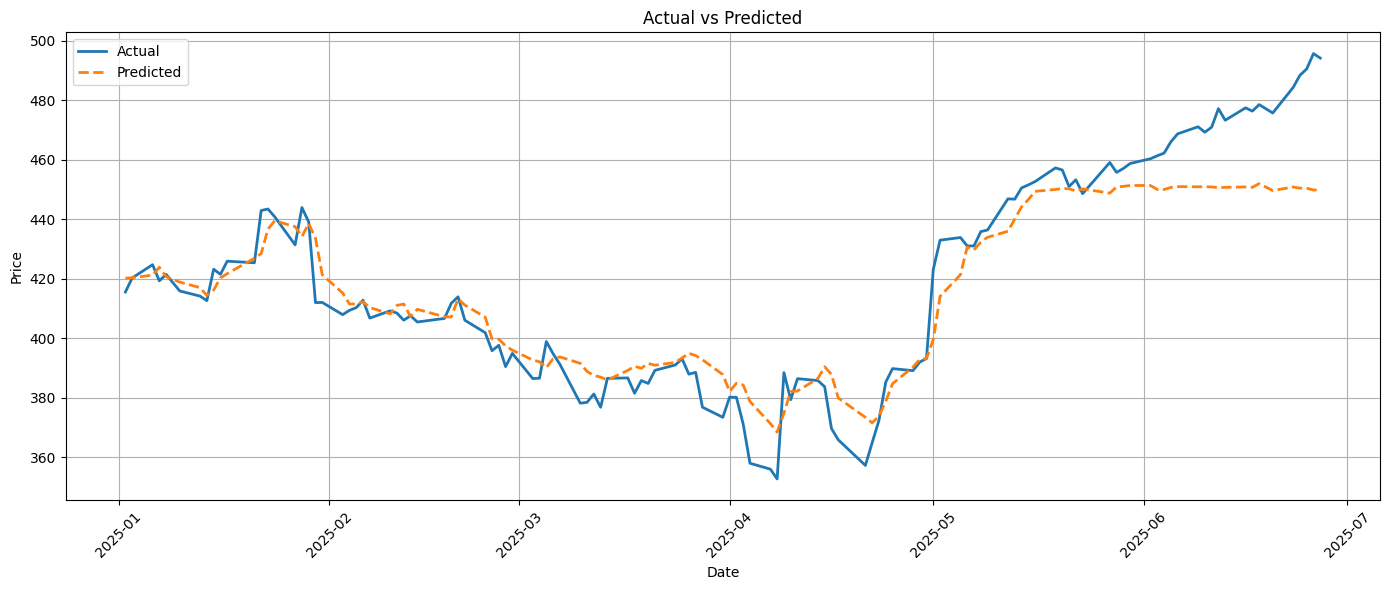

In [376]:
plt.figure(figsize=(14, 6))
plt.plot(rf_finalpred_df['Date'], rf_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(rf_finalpred_df['Date'], rf_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GradientBoost Model

In [377]:
gb_finalpred = gb_best_model.predict (x_final)

mse_gb_finalpred = mean_squared_error(y_final, gb_finalpred)
mae_gb_finalpred = mean_absolute_error(y_final, gb_finalpred)
mape_gb_finalpred = mean_absolute_percentage_error(y_final, gb_finalpred)

print("Final Prediction MSE:", mse_gb_finalpred)
print("Final Prediction MAE:", mae_gb_finalpred)
print("Final Prediction MAPE:", mape_gb_finalpred)

Final Prediction MSE: 190.1025104394491
Final Prediction MAE: 9.037032835638065
Final Prediction MAPE: 0.020732272024844903


In [378]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

gb_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': gb_finalpred,
    'Actual': y_final
})

gb_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,420.096131,415.514832
1280,2025-01-03,418.609973,420.249939
1281,2025-01-06,421.159602,424.716949
1282,2025-01-07,420.465153,419.277069
1283,2025-01-08,418.847459,421.451080
...,...,...,...
1395,2025-06-23,448.005106,484.295959
1396,2025-06-24,446.411021,488.391510
1397,2025-06-25,446.309222,490.543976
1398,2025-06-26,445.975103,495.705811


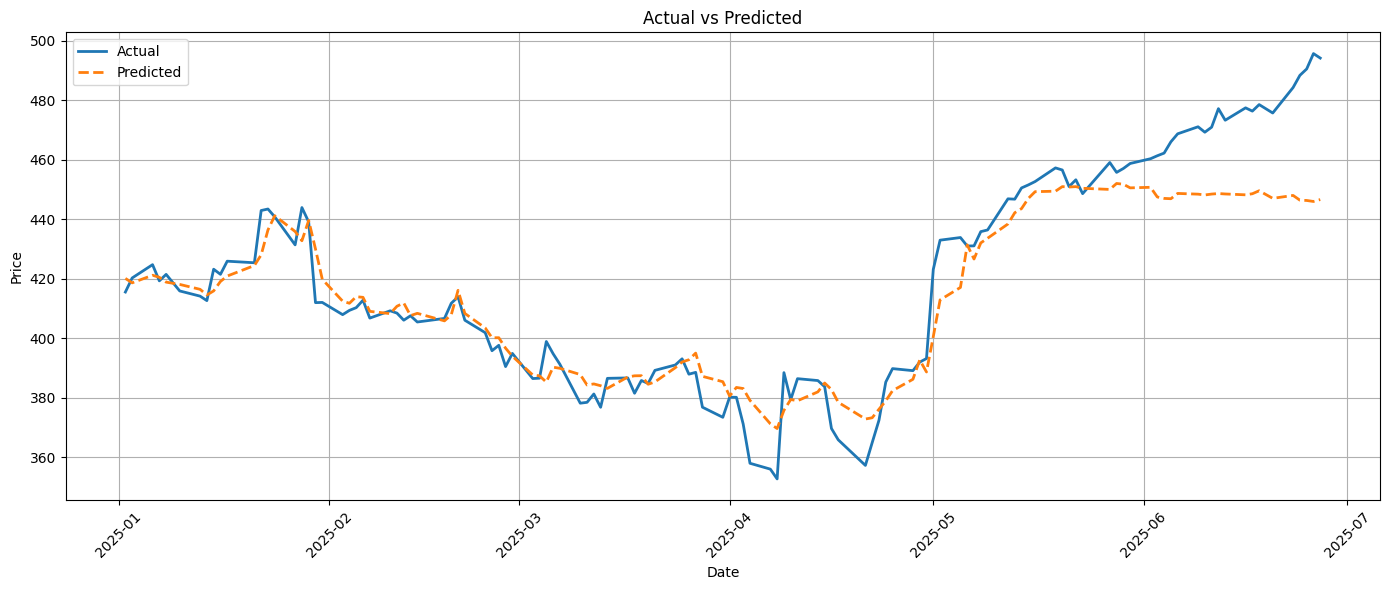

In [379]:
plt.figure(figsize=(14, 6))
plt.plot(gb_finalpred_df['Date'], gb_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(gb_finalpred_df['Date'], gb_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Neural Network Model

Data Preprocessing

In [380]:
x_final_scaled = x_scaler.transform(x_final)
y_final_scaled = y_scaler.transform(y_final.values.reshape(-1, 1))


In [381]:
NN_finalpred = model_NN.predict(x_final_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [382]:
NN_finalpred_real = y_scaler.inverse_transform(NN_finalpred)

In [383]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

NN_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': NN_finalpred_real.flatten(),
    'Actual': y_final
})

NN_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,423.309967,415.514832
1280,2025-01-03,421.591125,420.249939
1281,2025-01-06,423.419617,424.716949
1282,2025-01-07,426.731537,419.277069
1283,2025-01-08,424.541504,421.451080
...,...,...,...
1395,2025-06-23,473.016052,484.295959
1396,2025-06-24,479.632477,488.391510
1397,2025-06-25,486.204712,490.543976
1398,2025-06-26,489.452972,495.705811


In [384]:
predictions = NN_finalpred_df['Predicted'].values
actuals = NN_finalpred_df['Actual'].values

mse_NN_finalpred = mean_squared_error(actuals, predictions)
mae_NN_finalpred = mean_absolute_error(actuals, predictions)
mape_NN_finalpred = mean_absolute_percentage_error(actuals, predictions)


print("Final Prediction MSE:", mse_NN_finalpred)
print("Final Prediction MAE:", mae_NN_finalpred)
print("Final Prediction MAPE:", mape_NN_finalpred)

Final Prediction MSE: 84.81597833297685
Final Prediction MAE: 6.015126882505811
Final Prediction MAPE: 0.01477413238208324


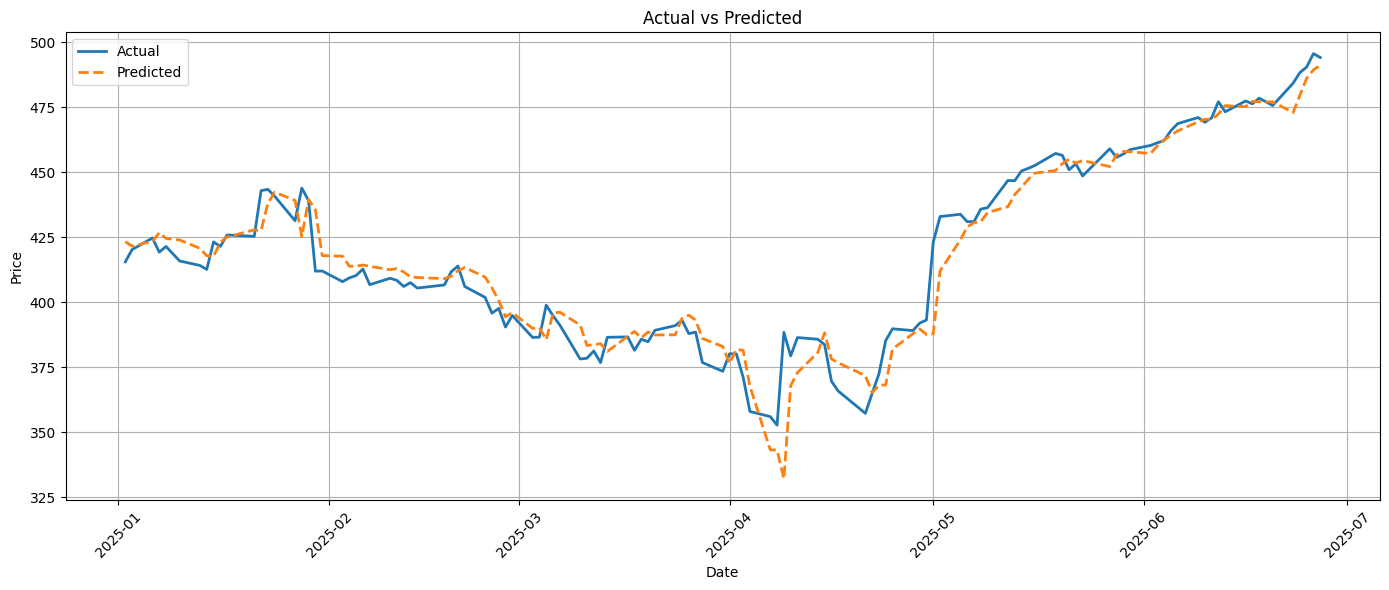

In [385]:
plt.figure(figsize=(14, 6))
plt.plot(NN_finalpred_df['Date'], NN_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(NN_finalpred_df['Date'], NN_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## SUMMARY

In [386]:
summary_df = pd.DataFrame({
    'Date': dates.values,
    'Actual': y_final,
    'Random Forest Prediction': rf_finalpred,
    'Gradient Boost Prediction': gb_finalpred,
    'Neural Network Prediction': NN_finalpred_real.flatten()
})

summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction
1279,2025-01-02,415.514832,420.164130,420.096131,423.309967
1280,2025-01-03,420.249939,420.333917,418.609973,421.591125
1281,2025-01-06,424.716949,421.198092,421.159602,423.419617
1282,2025-01-07,419.277069,423.865171,420.465153,426.731537
1283,2025-01-08,421.451080,420.683585,418.847459,424.541504
...,...,...,...,...,...
1395,2025-06-23,484.295959,450.840056,448.005106,473.016052
1396,2025-06-24,488.391510,450.451191,446.411021,479.632477
1397,2025-06-25,490.543976,450.419739,446.309222,486.204712
1398,2025-06-26,495.705811,449.834141,445.975103,489.452972


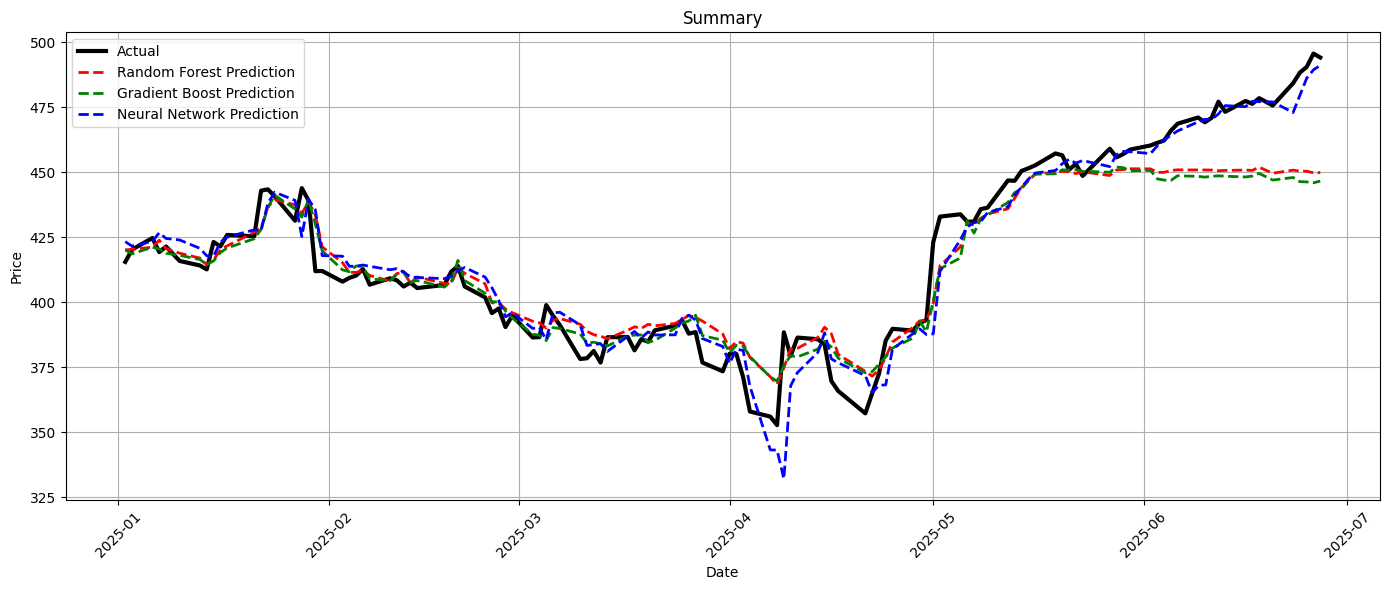

In [387]:
plt.figure(figsize=(14, 6))
plt.plot(summary_df['Date'], summary_df['Actual'], label='Actual', linewidth=3, color="black")
plt.plot(summary_df['Date'], summary_df['Random Forest Prediction'], label='Random Forest Prediction', linewidth=2, linestyle='--', color='red')
plt.plot(summary_df['Date'], summary_df['Gradient Boost Prediction'], label='Gradient Boost Prediction', linewidth=2, linestyle='--', color='green')
plt.plot(summary_df['Date'], summary_df['Neural Network Prediction'], label='Neural Network Prediction', linewidth=2, linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Summary')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Further Improvement -- Model Ensemble

In [388]:
summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction
1279,2025-01-02,415.514832,420.164130,420.096131,423.309967
1280,2025-01-03,420.249939,420.333917,418.609973,421.591125
1281,2025-01-06,424.716949,421.198092,421.159602,423.419617
1282,2025-01-07,419.277069,423.865171,420.465153,426.731537
1283,2025-01-08,421.451080,420.683585,418.847459,424.541504
...,...,...,...,...,...
1395,2025-06-23,484.295959,450.840056,448.005106,473.016052
1396,2025-06-24,488.391510,450.451191,446.411021,479.632477
1397,2025-06-25,490.543976,450.419739,446.309222,486.204712
1398,2025-06-26,495.705811,449.834141,445.975103,489.452972


In [389]:
rmse_rf = np.sqrt(mse_rf_finalpred)
rmse_gb = np.sqrt(mse_gb_finalpred)
rmse_nn = np.sqrt(mse_NN_finalpred)

total = (1/rmse_rf) + (1/rmse_gb) + (1/rmse_nn)
weights_rmse = [
    (1/rmse_rf)/total,
    (1/rmse_gb)/total,
    (1/rmse_nn)/total
]

summary_df['Ensemble Method Prediction'] = (
    weights_rmse[0] * summary_df['Random Forest Prediction'] +
    weights_rmse[1] * summary_df['Gradient Boost Prediction'] +
    weights_rmse[2] * summary_df['Neural Network Prediction']
)

# total_performance = (1/mse_rf_finalpred) + (1/mape_gb_finalpred) + (1/mape_NN_finalpred)
# weights_smart = [
#     (1/mape_rf_finalpred) / total_performance,
#     (1/mape_gb_finalpred) / total_performance,
#     (1/mape_NN_finalpred) / total_performance
# ]

# total_performance = (1/mape_rf_finalpred) + (1/mape_gb_finalpred) + (1/mape_NN_finalpred)


# summary_df['Ensemble Method Prediction'] = (
#     weights_smart[0] * summary_df['Random Forest Prediction'] +
#     weights_smart[1] * summary_df['Gradient Boost Prediction'] +
#     weights_smart[2] * summary_df['Neural Network Prediction']
# )

# Calculate ensemble MSE
ensemble_pred = summary_df['Ensemble Method Prediction'].values
actual = summary_df['Actual'].values
mse_ensemble = np.mean((actual - ensemble_pred) ** 2)


mse_ensemble_finalpred = mean_squared_error(actuals, ensemble_pred)
mae_ensemble_finalpred = mean_absolute_error(actuals, ensemble_pred)
mape_ensemble_finalpred = mean_absolute_percentage_error(actuals, ensemble_pred)


print("Final Prediction MSE:", mse_ensemble_finalpred)
print("Final Prediction MAE:", mae_ensemble_finalpred)
print("Final Prediction MAPE:", mape_ensemble_finalpred)

Final Prediction MSE: 103.76318615985514
Final Prediction MAE: 7.355372679842574
Final Prediction MAPE: 0.017236177688805813


In [397]:
weights_rmse

[np.float64(0.2961080524101006),
 np.float64(0.2818820995978193),
 np.float64(0.42200984799208)]

In [390]:
summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction,Ensemble Method Prediction
1279,2025-01-02,415.514832,420.164130,420.096131,423.309967,421.472537
1280,2025-01-03,420.249939,420.333917,418.609973,421.591125,420.378519
1281,2025-01-06,424.716949,421.198092,421.159602,423.419617,422.124755
1282,2025-01-07,419.277069,423.865171,420.465153,426.731537,424.116406
1283,2025-01-08,421.451080,420.683585,418.847459,424.541504,421.794104
...,...,...,...,...,...,...
1395,2025-06-23,484.295959,450.840056,448.005106,473.016052,459.399422
1396,2025-06-24,488.391510,450.451191,446.411021,479.632477,461.627138
1397,2025-06-25,490.543976,450.419739,446.309222,486.204712,464.362674
1398,2025-06-26,495.705811,449.834141,445.975103,489.452972,465.465895


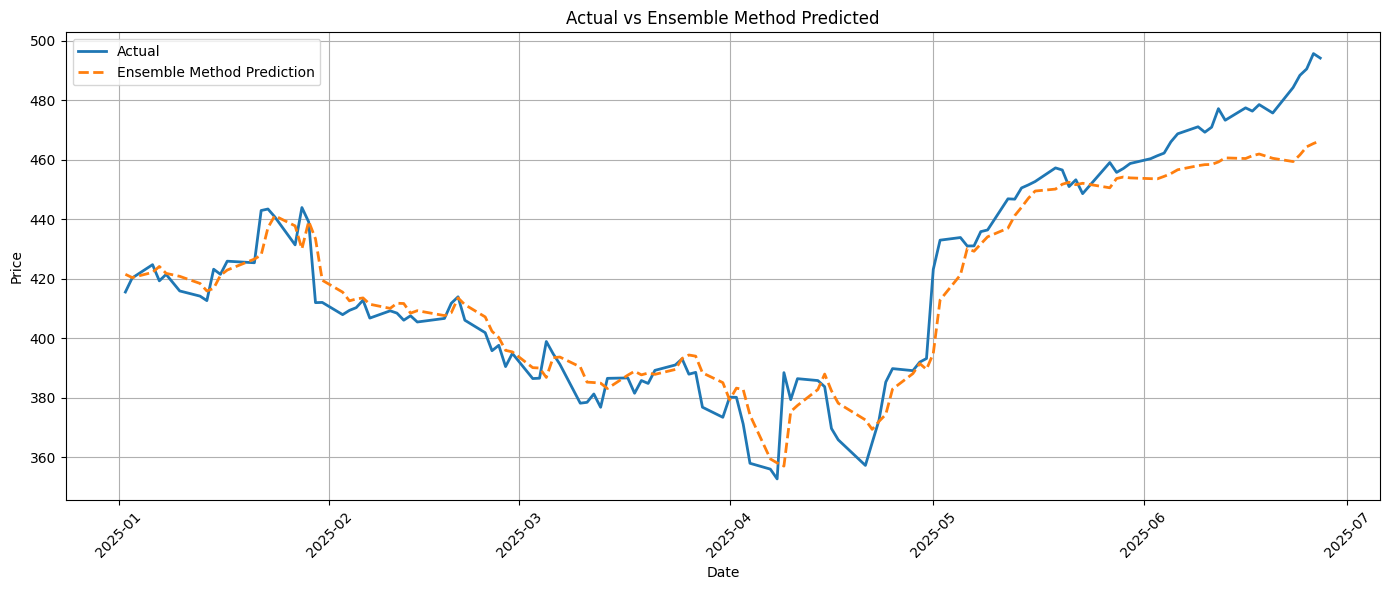

In [391]:
plt.figure(figsize=(14, 6))
plt.plot(summary_df['Date'], summary_df['Actual'], label='Actual', linewidth=2)
plt.plot(summary_df['Date'], summary_df['Ensemble Method Prediction'], label='Ensemble Method Prediction', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Ensemble Method Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()